In [1]:
import pandas as pd
import numpy as np
import pricey as pr
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import FinanceDataReader as fdr
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
import statsmodels.api as sm
import itertools
from IPython.core.debugger import set_trace
import seaborn as sns
import arviz as az

from sklearnex import patch_sklearn
patch_sklearn()

# import warnings
# warnings.filterwarnings(action='ignore')

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler#, Imputer
from sklearn.cluster import KMeans, DBSCAN

%matplotlib inline

import pymc as pm
import aesara as asr

az.style.use("arviz-darkgrid")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# import matplotlib.pyplot as plt
 
# # 한글 폰트 사용을 위해서 세팅
# from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

In [3]:
univ = pd.read_excel('ticker_map.xlsx', converters={'code':str})
univ = list(univ['code']); univ

['005930',
 '005935',
 '000660',
 '006400',
 '006405',
 '051910',
 '051915',
 '005380',
 '005385',
 '035420',
 '068270',
 '000270',
 '035720',
 '105560',
 '005490',
 '055550',
 '207940',
 '012330',
 '373220',
 '028260',
 '086790',
 '033780',
 '066570',
 '066575',
 '096770',
 '316140',
 '017670',
 '034730',
 '003550',
 '030200',
 '009150',
 '259960',
 '036570',
 '323410',
 '000810',
 '009830',
 '015760',
 '032830',
 '051900',
 '010130',
 '011200',
 '003490',
 '034020',
 '003670',
 '011070',
 '018260',
 '402340',
 '028050',
 '009540',
 '010950',
 '010140',
 '352820',
 '047810',
 '097950',
 '090430',
 '034220',
 '021240',
 '000100',
 '035250',
 '086280',
 '032640',
 '251270',
 '000720',
 '011170',
 '267250',
 '004020',
 '024110',
 '161390',
 '377300',
 '010620',
 '005830',
 '011780',
 '008770',
 '383220',
 '271560',
 '006800',
 '329180',
 '071050',
 '012450',
 '018880',
 '078930',
 '016360',
 '011790',
 '001450',
 '139480',
 '010060',
 '128940',
 '138930',
 '004170',
 '030000',
 '302440',

In [20]:
_dflist = [fdr.DataReader(code, '2019-01-01') for code in tqdm(univ)]

  0%|          | 0/147 [00:00<?, ?it/s]

In [21]:
p = pd.concat([_s['Close'] for _s in _dflist], axis=1)
p.columns = univ
logp = np.log(p); logp.head()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,10.564886,10.360912,11.012050,12.257241,11.359774,12.727838,12.162643,11.643954,11.136048,11.678440,...,11.901583,11.716111,8.930230,9.888374,10.089386,9.335209,9.684398,9.148465,9.170560,11.653661
2019-01-03,10.534759,10.335270,10.963012,12.220961,11.326596,12.700769,12.136187,11.665647,11.153389,11.711776,...,11.845820,11.704033,8.909100,9.849559,10.079623,9.311813,9.697693,9.152711,9.178850,11.653991
2019-01-04,10.530762,10.323841,10.973357,12.211060,11.304671,12.708362,12.122691,11.691072,11.161949,11.740061,...,11.820410,11.724077,8.916238,9.880731,10.087225,9.330343,9.736547,9.154828,9.176266,11.651600
2019-01-07,10.564886,10.376611,10.980195,12.287653,11.357441,12.745486,12.154779,11.699405,11.159104,11.786762,...,11.904968,11.739822,8.930230,9.935471,10.101313,9.337678,9.764800,9.151121,9.170039,11.652009
2019-01-08,10.547970,10.338511,10.988677,12.294541,11.363265,12.764259,12.173033,11.691072,11.154821,11.775290,...,11.877569,11.739822,8.924124,9.987369,10.094934,9.325542,9.760194,9.146335,9.174195,11.650773


In [22]:
p_open = pd.concat([_s['Open'] for _s in _dflist], axis=1)
p_open.columns = univ; p_open.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-03,64000,54300,89700,750000,338000,728000,318000,184600,94600,203500,...,183200,80600,8750,15660,32785,13070,14600,12780,11770,112000
2023-04-04,63400,53800,85700,740000,337000,717000,320500,184000,94700,198200,...,173500,80200,8730,15570,32555,12910,14615,12955,11820,111680
2023-04-05,63700,53300,84300,730000,343500,722000,323500,185100,94100,201000,...,172300,80600,8900,15730,32680,13015,14695,13195,11860,111960
2023-04-06,63500,53400,83900,764000,345500,728000,327000,186900,94900,198200,...,171500,79900,8940,15400,32720,13350,14610,13190,11900,112120
2023-04-07,63800,54100,87900,742000,340000,720000,321000,185400,94300,193000,...,171100,80200,8950,15090,32510,13210,14630,13115,11920,113300


In [23]:
pairs = [
    ['005930', '005935'], # 삼성전자
    ['066570', '066575'], # LG전자
    ['006400', '006405'], # 삼성SDI
    ['051910', '051915'], # LG화학
    ['005380', '005385'], # 현대차
]

_from, _to = '2020-01-01', '2023-03-31'

stock1_name, stock2_name = pairs[0]
orig_data = logp.loc[_from:_to,[stock1_name, stock2_name]]
p_data = p.loc[_from:_to,[stock1_name, stock2_name]]
p_open_data = p_open.loc[_from:_to,[stock1_name, stock2_name]]

data = orig_data.diff().cumsum()
data1 = data[stock1_name].ffill().fillna(0).values
data2 = data[stock2_name].ffill().fillna(0).values

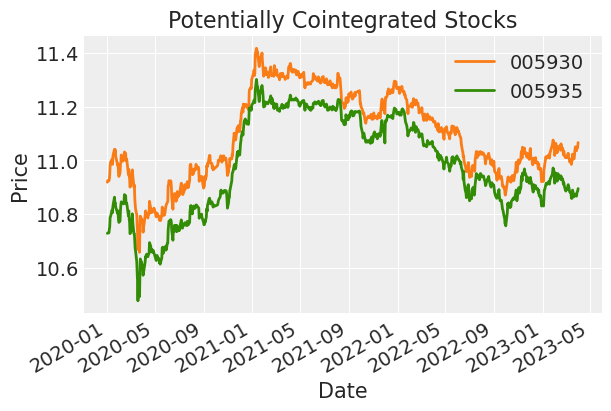

In [24]:
plt.figure(figsize = (6,4))
ax = plt.gca()
plt.title("Potentially Cointegrated Stocks")
orig_data[stock1_name].plot(ax=ax,color=sns.color_palette()[1],linewidth=2)
orig_data[stock2_name].plot(ax=ax,color=sns.color_palette()[2],linewidth=2)
plt.ylabel("Price")
plt.legend()
plt.show()

<Axes: xlabel='Date'>

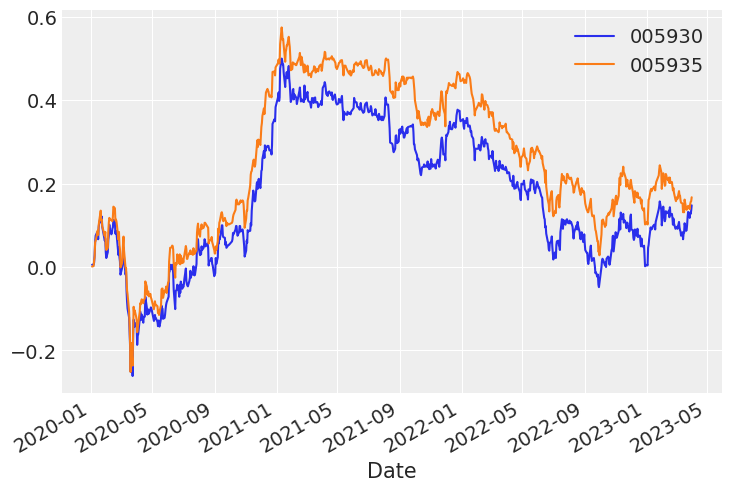

In [25]:
data[[stock1_name, stock2_name]].plot()

In [26]:
data.shape

(804, 2)

In [14]:
with pm.Model() as model:
    
    stock1 = data1
    stock2 = data2
    
    # define our cointegration variables
    beta_sigma = pm.Exponential('beta_sigma', 50.)
    beta = pm.GaussianRandomWalk('beta', sigma=beta_sigma, shape=data1.shape[0])
    
    # with our assumptions, cointegration can be reframed as a regression problem
    stock2_regression = beta * stock1
    
    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sigma=.1)
    likelihood = pm.Normal('y', mu=stock2_regression, sigma=sd, observed=stock2)

with model:
    idata = pm.sample(chains=2, cores=8)

/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/distributions/timeseries.py:301: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 55 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


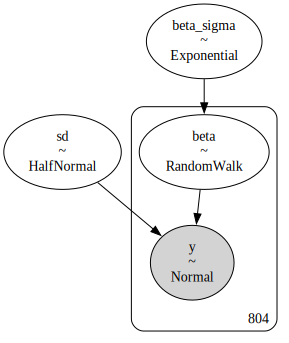

In [18]:
pm.model_to_graphviz(model)

In [15]:
rolling_beta = idata.posterior['beta'].T.mean(axis=1)[:,0]#.mean(axis=1)

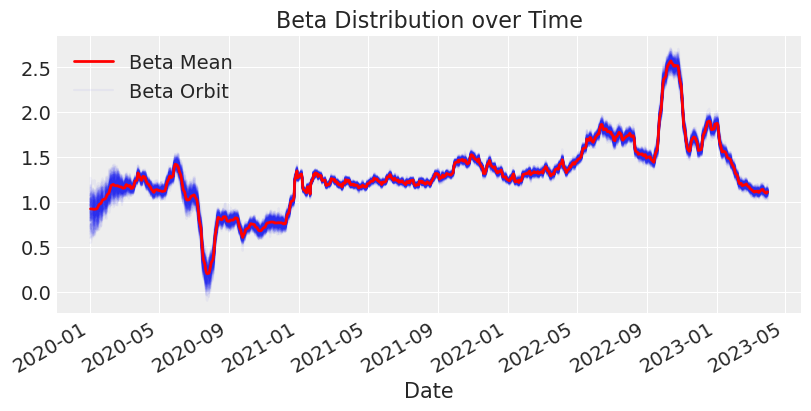

In [15]:
plt.figure(figsize = (8,4))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta,index=orig_data.index).plot(ax=ax,color='r',zorder=1e6,linewidth=2)

for orbit in idata.posterior['beta'].sel(draw=slice(0,200))[0]:
    pd.Series(orbit,index=orig_data.index).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05)
    

plt.legend(['Beta Mean','Beta Orbit'])
plt.show()

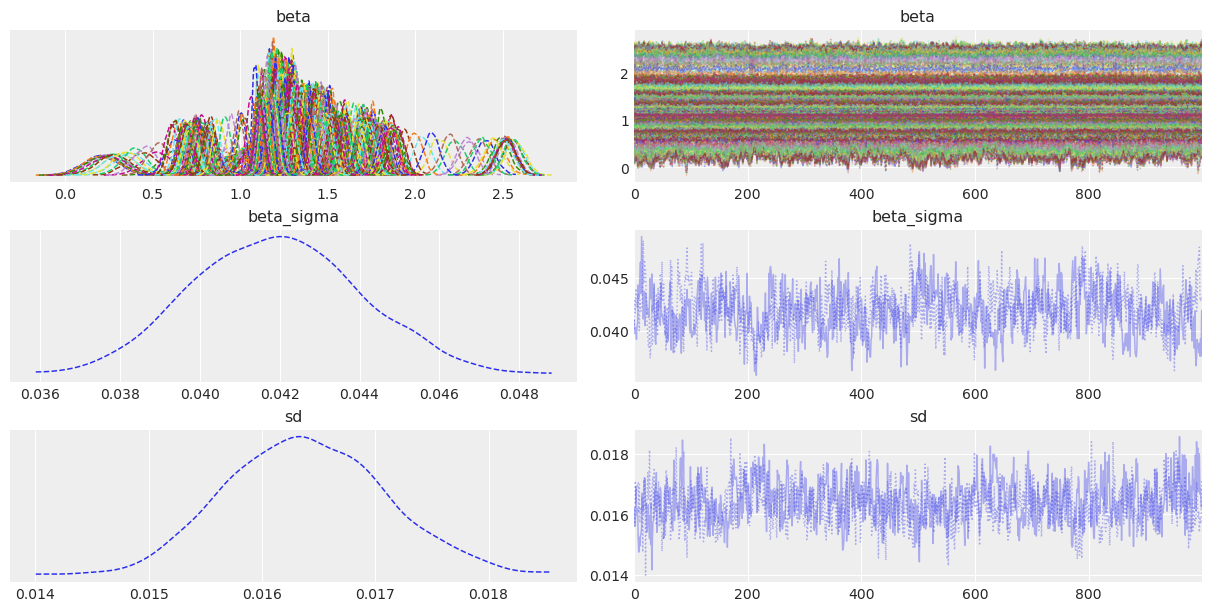

In [21]:
az.plot_trace(idata, combined=True);

In [16]:
def getStrategyPortfolioWeights(rolling_beta, stock_name1, stock_name2, data, smoothing_window=15):
    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    # initial signal rebalance
    #fixed_beta = float(rolling_beta[smoothing_window])
    #signal = fixed_beta*data1 - data2
    #smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
    #d_smoothed_signal = smoothed_signal.diff()
    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    
    for i in range(smoothing_window, data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":
            # dynamically rebalance the signal when not trading
            fixed_beta = float(rolling_beta[i])
            signal = fixed_beta*data1 - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()

            if smoothed_signal[i] > 0 and d_smoothed_signal[i] < 0:
                #leverage.iloc[i,0] = -fixed_beta / (abs(fixed_beta)+1)
                #leverage.iloc[i,1] = 1 / (abs(fixed_beta)+1)
                
                w0 = -fixed_beta / (abs(fixed_beta)+1)
                w1 = 1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = w0 / w_max
                leverage.iloc[i,1] = w1 / w_max
                
                trading = "short"
                trading_start = smoothed_signal[i]
                
            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0

        elif trading=="short":
            # a failed trade
            if smoothed_signal[i] > trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] < 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage

In [17]:
def backtest(pricingDF, openDF, leverageDF, start_cash):
    pricing = pricingDF.values
    pricing_open = openDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = cash[1] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    
    total_cost = 0
    pnl_hist = np.zeros(pricing.shape[0])
    pnl = []
    values = np.zeros(pricing.shape[0])
    values[0] = values[1] = start_cash

    
    for t in range(2, pricing.shape[0]):
        if np.any(leverage[t-1] != leverage[t-2]):
            target_shares = (start_cash * leverage[t-1] / pricing[t-1]).astype(int)
            
            # rebalance
            shares[t] = target_shares
            cost0 = abs(shares[t,0] - shares[t-1,0]) * pricing_open[t,0] * 0.0001
            cost1 = abs(shares[t,1] - shares[t-1,1]) * pricing_open[t,1] * (0.00025 if shares[t,1] > shares[t-1,1] else 0.00225)

            cash[t] = cash[t-1] - ((shares[t]-shares[t-1]) * pricing_open[t]).sum() - cost0 - cost1
            total_cost += (cost0 + cost1)
            #set_trace()
            
        else:
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
            
        values[t] = (shares[t] * pricing[t]).sum() + cash[t]
            
        if shares[t-1,0]==0 and shares[t,0]!=0:
            pnl_hist[t] = values[t] - values[t-1]
            
        elif shares[t,0]!=0 or (shares[t-1,0]!=0 and shares[t,0]==0):
            pnl_hist[t] = pnl_hist[t-1] + values[t] - values[t-1]
            
        if shares[t-1,0]!=0 and shares[t,0]==0:
            pnl.append(pnl_hist[t])
    
    
    pct_returns = (values - start_cash) / start_cash
    
    n_days = pct_returns.shape[0]
    total_profit = int(values[-1] - start_cash)
    total_return = pct_returns[-1] * 100
    total_cost_rate = total_cost / total_profit * 100
    n_entry = len(pnl)
    n_entry_monthly = n_entry / n_days * 20
    n_entry_days = (portfolioWeights.iloc[:,0] != 0).sum()
    n_holding_days = n_entry_days / n_entry
    pnl_by_entry = total_profit / n_entry
    profit_of_profit_entry = np.mean(list(filter(lambda x: x>0, pnl)))
    loss_of_loss_entry = np.mean(list(filter(lambda x: x<0, pnl)))

    print(f'테스트 일수: {n_days}일')
    print(f'총손익 (투자금액대비%): {format(total_profit, ",")}원 ({total_return:.3f}%)')
    print(f'총비용 (총손익대비%): {format(int(total_cost), ",")}원 ({total_cost_rate:.3f}%)')
    print(f'진입횟수: {n_entry}회')
    print(f'월평균 진입횟수: {n_entry_monthly:.2f}회')
    print(f'진입일수 (전체일수대비%): {n_entry_days}일 ({n_entry_days/n_days*100:.2f}%)')
    print(f'평균보유일수: {n_holding_days:.2f}일')
    print(f'진입당 평균손익: {format(int(pnl_by_entry), ",")}원')
    print(f'최대수익: {format(int(max(pnl)), ",")}원')
    print(f'최대손실: {format(int(min(pnl)), ",")}원')
    print(f'수익진입의 평균수익: {format(int(profit_of_profit_entry), ",")}원')
    print(f'손실진입의 평균손실: {format(int(loss_of_loss_entry), ",")}원')
    
    return (
        pd.DataFrame(shares, index=pricingDF.index, columns=pricingDF.columns),
        pd.Series(cash, index=pricingDF.index),
        pd.Series(pct_returns, index=pricingDF.index),
        pd.Series(values, index=pricingDF.index),
        pd.Series(pnl_hist, index=pricingDF.index),
        pd.Series(pnl)
    )

<Axes: xlabel='Date'>

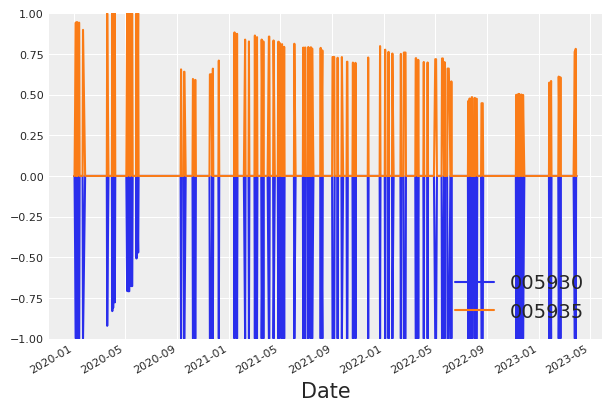

In [29]:
portfolioWeights = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1).fillna(0)
portfolioWeights.plot(figsize=(6,4), ylim=(-1,1), fontsize=8)

In [28]:
# portfolioWeights.sum(axis=1).plot(figsize=(6,4), ylim=(-1,1), fontsize=8)

# 삼성전자

테스트 일수: 804일
총손익 (투자금액대비%): 14,603,900원 (14.604%)
총비용 (총손익대비%): 16,796,599원 (115.014%)
진입횟수: 82회
월평균 진입횟수: 2.04회
진입일수 (전체일수대비%): 108일 (13.43%)
평균보유일수: 1.32일
진입당 평균손익: 178,096원
최대수익: 2,660,835원
최대손실: -1,473,684원
수익진입의 평균수익: 743,051원
손실진입의 평균손실: -543,791원


<Axes: xlabel='Date'>

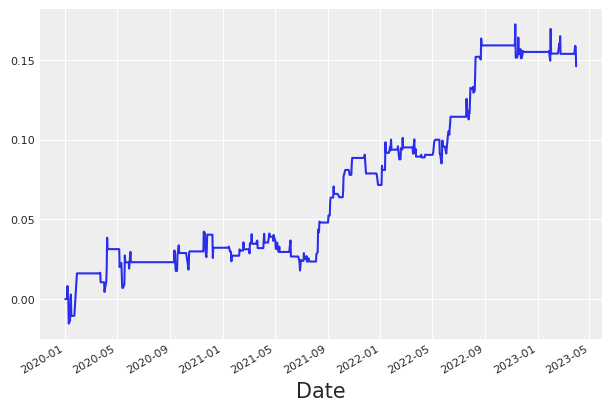

In [107]:
shares0, cash0, returns0, values0, pnl_hist0, pnl0 = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns0.plot(figsize=(6,4), fontsize=8)

# LG전자

테스트 일수: 804일
총손익 (투자금액대비%): 52,634,836원 (52.635%)
총비용 (총손익대비%): 18,678,363원 (35.487%)
진입횟수: 83회
월평균 진입횟수: 2.06회
진입일수 (전체일수대비%): 99일 (12.31%)
평균보유일수: 1.19일
진입당 평균손익: 634,154원
최대수익: 24,312,212원
최대손실: -4,395,385원
수익진입의 평균수익: 1,611,985원
손실진입의 평균손실: -1,093,346원


<Axes: xlabel='Date'>

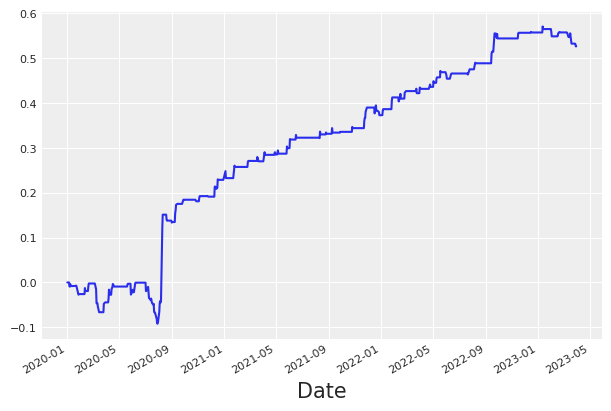

In [115]:
shares1, cash1, returns1, values1, pnl_hist1, pnl1 = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns1.plot(figsize=(6,4), fontsize=8)

# 삼성SDI

테스트 일수: 804일
총손익 (투자금액대비%): 98,427,986원 (98.428%)
총비용 (총손익대비%): 15,825,013원 (16.078%)
진입횟수: 76회
월평균 진입횟수: 1.89회
진입일수 (전체일수대비%): 107일 (13.31%)
평균보유일수: 1.41일
진입당 평균손익: 1,295,105원
최대수익: 21,219,311원
최대손실: -2,419,419원
수익진입의 평균수익: 2,669,869원
손실진입의 평균손실: -1,061,633원


<Axes: xlabel='Date'>

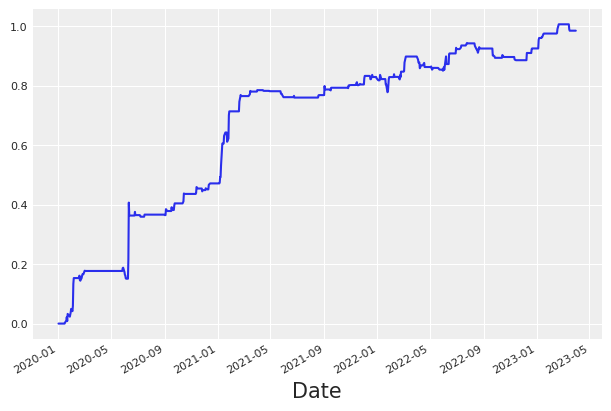

In [123]:
shares2, cash2, returns2, values2, pnl_hist2, pnl2 = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns2.plot(figsize=(6,4), fontsize=8)

# LG화학

테스트 일수: 804일
총손익 (투자금액대비%): 74,130,610원 (74.131%)
총비용 (총손익대비%): 22,167,889원 (29.904%)
진입횟수: 83회
월평균 진입횟수: 2.06회
진입일수 (전체일수대비%): 120일 (14.93%)
평균보유일수: 1.45일
진입당 평균손익: 893,139원
최대수익: 12,176,430원
최대손실: -4,787,248원
수익진입의 평균수익: 1,951,669원
손실진입의 평균손실: -1,302,329원


<Axes: xlabel='Date'>

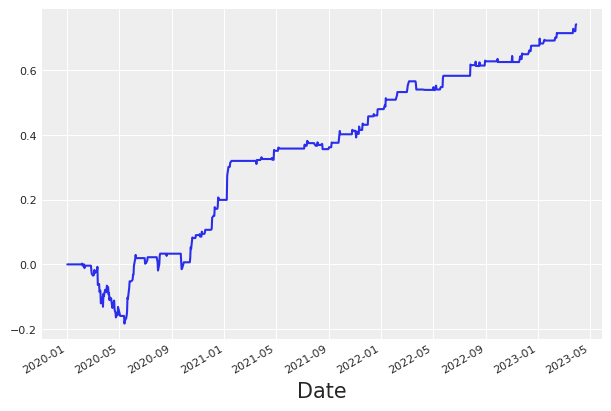

In [131]:
shares3, cash3, returns3, values3, pnl_hist3, pnl3 = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns3.plot(figsize=(6,4), fontsize=8)

# 현대차

테스트 일수: 804일
총손익 (투자금액대비%): 23,881,584원 (23.882%)
총비용 (총손익대비%): 28,205,265원 (118.105%)
진입횟수: 109회
월평균 진입횟수: 2.71회
진입일수 (전체일수대비%): 167일 (20.77%)
평균보유일수: 1.53일
진입당 평균손익: 219,097원
최대수익: 6,550,799원
최대손실: -4,069,800원
수익진입의 평균수익: 1,067,126원
손실진입의 평균손실: -871,603원


<Axes: xlabel='Date'>

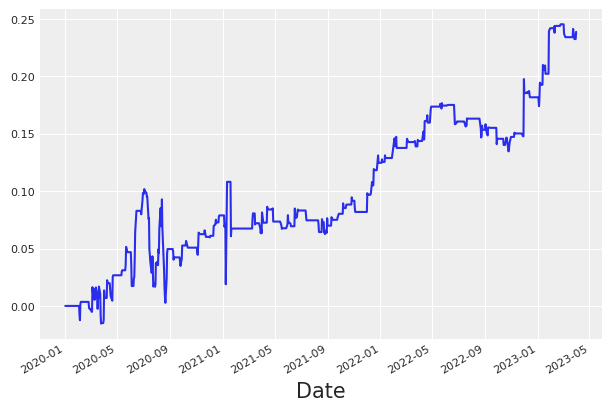

In [139]:
shares4, cash4, returns4, values4, pnl_hist4, pnl4 = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns4.plot(figsize=(6,4), fontsize=8)

<Axes: xlabel='Date'>

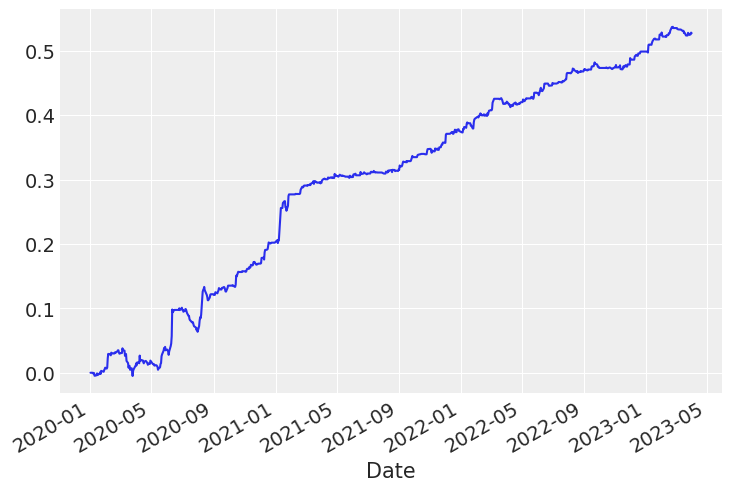

In [142]:
total_values = values0 + values1 + values2 + values3 + values4
((total_values / total_values.iloc[0]) - 1).plot()

<Axes: xlabel='Date'>

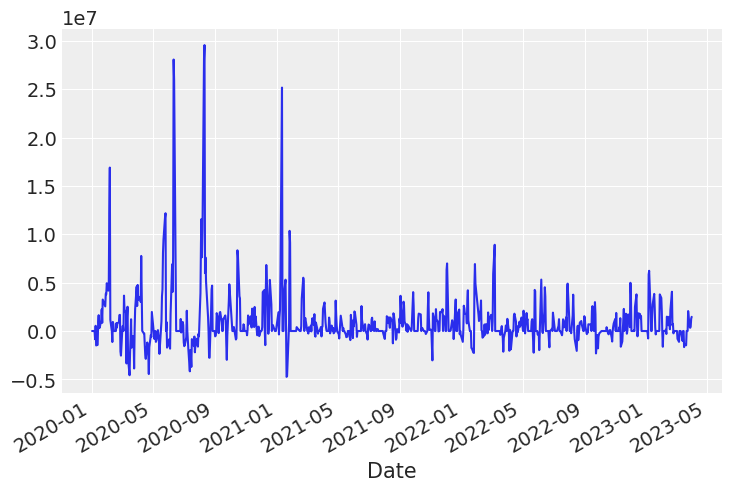

In [146]:
(pnl_hist0 + pnl_hist1 + pnl_hist2 + pnl_hist3 + pnl_hist4).plot()